In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: C:\D disk\ID2223_lab1\mlfs-book
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-07 11:34:16,099 INFO: Initializing external client
2025-11-07 11:34:16,102 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-07 11:34:20,940 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271980


In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [5]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])


#selected_features = (
 #   air_quality_fg.select(['pm25', 'date', 'city'])
  #  .join(weather_fg.select_all(), on=['city', 'date'])
#)


df_preview = selected_features.read()
df_preview.head()


2025-11-07 11:34:25,351 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.96s) 


,pm25,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,129.0,2014-01-01 00:00:00+00:00,1.164167,0.0,14.154915,264.003693
1,193.0,2014-01-02 00:00:00+00:00,0.435000,0.0,11.525623,351.280304
2,110.0,2014-01-03 00:00:00+00:00,-0.119167,0.0,11.966953,90.520851
3,196.0,2014-01-04 00:00:00+00:00,-2.660833,0.0,7.568566,20.897827
4,153.0,2014-01-05 00:00:00+00:00,-1.271250,0.0,11.486200,102.660622


In [6]:
# just to cocnfirm if we have the right format

df = selected_features.read()  #
print("rows:", len(df))


uniq = df.groupby(['date']).size().sort_values(ascending=False).head(10)
print(uniq)  # 若出现 >1 的计数，说明按 city 的 join 发生了倍增

df2 = (
    air_quality_fg.select(['pm25','date','city'])
    .join(weather_fg.select_features(), on=['city'])
).read()
dup = df2.groupby(['city','date']).size().sort_values(ascending=False).head(10)
print(dup)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (12.27s) 
rows: 4246
date
2014-01-01 00:00:00+00:00    1
2021-12-27 00:00:00+00:00    1
2021-12-13 00:00:00+00:00    1
2021-12-14 00:00:00+00:00    1
2021-12-15 00:00:00+00:00    1
2021-12-16 00:00:00+00:00    1
2021-12-17 00:00:00+00:00    1
2021-12-18 00:00:00+00:00    1
2021-12-19 00:00:00+00:00    1
2021-12-20 00:00:00+00:00    1
dtype: int64
2025-11-07 11:34:45,850 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.87s) 
city     date                     
beijing  2014-01-01 00:00:00+00:00    1
         2021-12-27 00:00:00+00:00    1
         2021-12-13 00:00:00+00:00    1
         2021-12-14 00:00:00+00:00    1
         2021-12-15 00:00:00+00:00    1
       

### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [7]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [8]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [9]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (11.96s) 


In [10]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2014-01-01 00:00:00+00:00,1.164167,0.0,14.154915,264.003693
1,2014-01-02 00:00:00+00:00,0.435000,0.0,11.525623,351.280304
2,2014-01-03 00:00:00+00:00,-0.119167,0.0,11.966953,90.520851
3,2014-01-04 00:00:00+00:00,-2.660833,0.0,7.568566,20.897827
4,2014-01-05 00:00:00+00:00,-1.271250,0.0,11.486200,102.660622
...,...,...,...,...,...
4050,2025-04-26 00:00:00+00:00,21.160250,0.0,20.757051,353.850555
4051,2025-04-27 00:00:00+00:00,19.331083,0.0,17.856325,300.839630
4052,2025-04-28 00:00:00+00:00,18.879000,0.0,16.575644,129.157227
4053,2025-04-29 00:00:00+00:00,23.841501,0.0,16.974487,278.392761


In [11]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [12]:
y_train

,pm25
0,129.0
1,193.0
2,110.0
3,196.0
4,153.0
...,...
4050,146.0
4051,29.0
4052,69.0
4053,78.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [13]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 3568.292
R squared: -1.9330744263958541


In [15]:
df = y_test
df['predicted_pm25'] = y_pred

In [16]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
4055,42.0,93.770836,2025-05-01 00:00:00+00:00
4056,63.0,105.251175,2025-05-02 00:00:00+00:00
4057,35.0,88.982567,2025-05-03 00:00:00+00:00
4058,68.0,152.427917,2025-05-04 00:00:00+00:00
4059,99.0,54.531078,2025-05-05 00:00:00+00:00


In [17]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

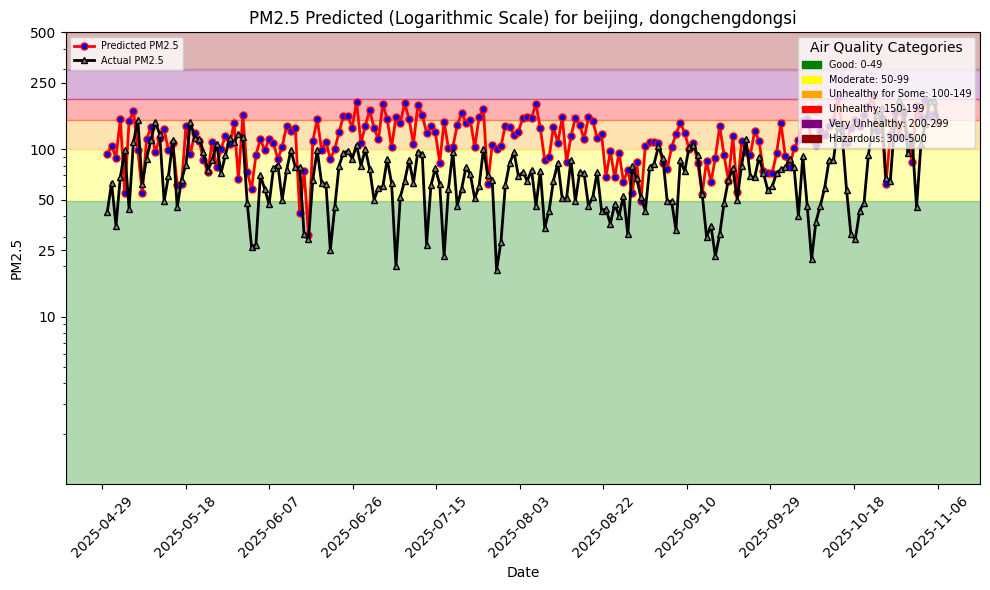

In [18]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

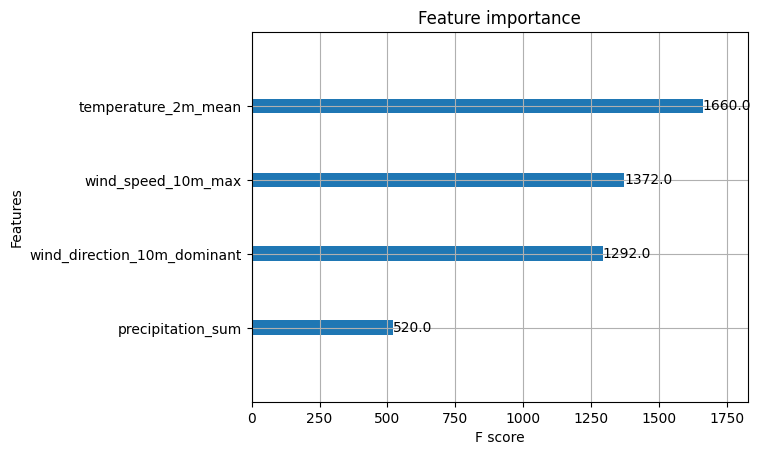

In [19]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [20]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [21]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [22]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model/model.json: 0.000%|          …

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model\images/feature_importance.png…

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model\images/feature_importance_v2.…

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model\images/feature_importance_v2_…

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model\images/pm25_hindcast.png: 0.0…

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model\images/pm25_hindcast_v2.png: …

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model\images/pm25_hindcast_v2_local…

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\model_schema.json: 0.000%|          | 0/605 ela…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271980/models/air_quality_xgboost_model/3


Model(name: 'air_quality_xgboost_model', version: 3)

# For Grade C (lagged PM2.5 + WEATHER)

In [46]:

air_quality_fg_v2 = fs.get_feature_group(
    name="air_quality",   
    version=2,            
)

weather_fg = fs.get_feature_group(
    name="weather",
    version=1,
)


aq_sel_v2 = air_quality_fg_v2.select([
    "pm25",
    "date",
    "pm25_lag1",
    "pm25_lag2",
    "pm25_lag3",
])


wx_sel = weather_fg.select_features()


selected_features_v2 = aq_sel_v2.join(
    wx_sel,
    on=["city"],
)


df_v2 = selected_features_v2.read()
print(df_v2.head())


feature_view_v2 = fs.get_or_create_feature_view(
    name="air_quality_fv",
    description="air_quality v2 with lagged pm25 + weather features; pm25 as target",
    version=2,
    labels=["pm25"],
    query=selected_features_v2,
)



2025-11-07 12:20:24,661 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.70s) 
    pm25                      date  pm25_lag1  pm25_lag2  pm25_lag3  \
0  196.0 2014-01-04 00:00:00+00:00      110.0      193.0      129.0   
1  153.0 2014-01-05 00:00:00+00:00      196.0      110.0      193.0   
2  193.0 2014-01-06 00:00:00+00:00      153.0      196.0      110.0   
3  161.0 2014-01-07 00:00:00+00:00      193.0      153.0      196.0   
4   86.0 2014-01-08 00:00:00+00:00      161.0      193.0      153.0   

   temperature_2m_mean  precipitation_sum  wind_speed_10m_max  \
0            -2.660833                0.0            7.568566   
1            -1.271250                0.0           11.486200   
2            -1.502500                0.0     

In [47]:

start_date_test_data = "2025-05-01"
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

X_train_2, X_test_2, y_train_2, y_test_2 = feature_view_v2.train_test_split(
    test_start=test_start
)

X_features_2 = X_train_2.drop(columns=["date","weather_date","city"])
X_test_features_2 = X_test_2.drop(columns=["date","weather_date","city"])


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.45s) 


In [48]:
#X_train_2

In [49]:
#y_train_2

In [50]:
#X_test_2

In [51]:
#y_test_2

In [52]:
#X_features_2

In [53]:
#X_test_features_2

In [54]:
# Creating an instance of the XGBoost Regressor
xgb_regressor_2 = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor_2.fit(X_features_2, y_train_2)

# Predicting target values on the test set
y_pred_2 = xgb_regressor_2.predict(X_test_features_2)

# Calculating Mean Squared Error (MSE) using sklearn
mse_2 = mean_squared_error(y_test_2.iloc[:,0], y_pred_2)
print("MSE:", mse_2)

# Calculating R squared using sklearn
r2_2 = r2_score(y_test_2.iloc[:,0], y_pred_2)
print("R squared:", r2_2)

MSE: 1224.8439
R squared: -0.006800398062393409


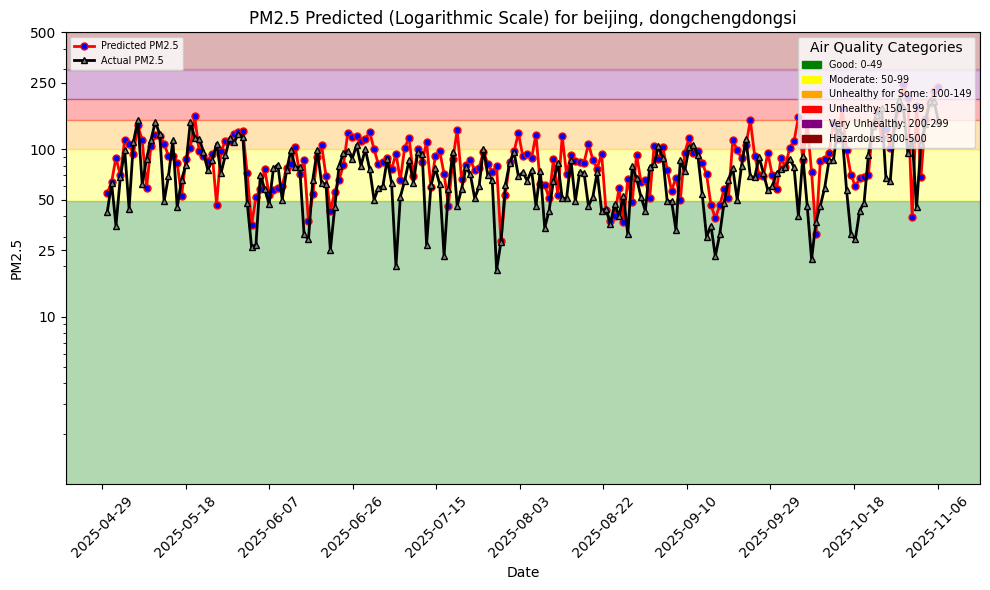

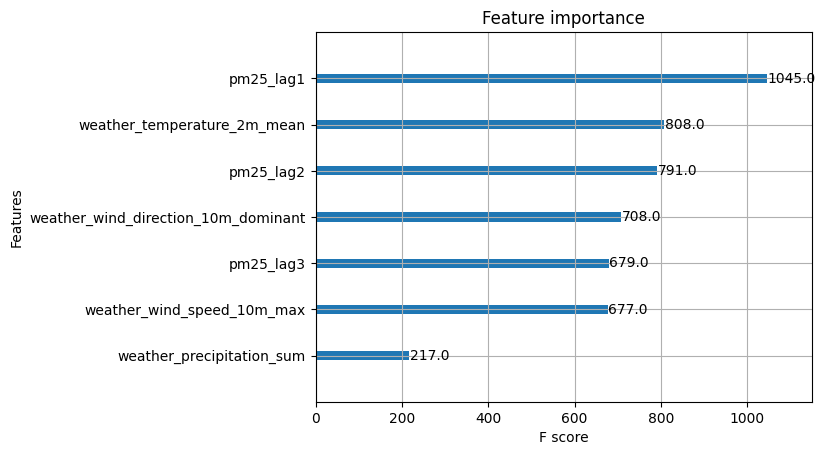

In [55]:
df_2 = y_test_2
df_2['predicted_pm25'] = y_pred_2

df_2['date'] = X_test_2['date']
df_2 = df_2.sort_values(by=['date'])
df_2.head(5)

# Creating a directory for the model artifacts if it doesn't exist
model_dir_2 = "air_quality_model_2"
if not os.path.exists(model_dir_2):
    os.mkdir(model_dir_2)
images_dir_2 = model_dir_2 + "/images"
if not os.path.exists(images_dir_2):
    os.mkdir(images_dir_2)

file_path_2 = images_dir_2 + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df_2, file_path_2, hindcast=True) 
plt.show()

# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor_2)
feature_importance_path_2 = images_dir_2 + "/feature_importance.png"
plt.savefig(feature_importance_path_2)
plt.show()

In [56]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor_2.save_model(model_dir_2 + "/model.json")

res_dict_2 = { 
        "MSE": str(mse_2),
        "R squared": str(r2_2),
    }

mr_2 = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model_2 = mr_2.python.create_model(
    name="air_quality_xgboost_model_C", 
    metrics= res_dict_2,
    feature_view=feature_view_v2,
    description="Air Quality (PM2.5) predictor C",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model_2.save(model_dir_2)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model_2/model.json: 0.000%|        …

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model_2\images/feature_importance.p…

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model_2\images/pm25_hindcast.png: 0…

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\model_schema.json: 0.000%|          | 0/1010 el…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271980/models/air_quality_xgboost_model_C/2


Model(name: 'air_quality_xgboost_model_C', version: 2)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
